# <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"> شبکه های مولد تخاصمی (GAN)</div>

In [1]:
!wget https://raw.githubusercontent.com/Alireza-Akhavan/deeplearning-tensorflow2-notebooks/master/dataset.py
!wget https://github.com/Alireza-Akhavan/deeplearning-tensorflow2-notebooks/raw/master/dataset/Data_hoda_full.mat -P dataset

--2024-02-13 12:46:24--  https://raw.githubusercontent.com/Alireza-Akhavan/deeplearning-tensorflow2-notebooks/master/dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 917 [text/plain]
Saving to: ‘dataset.py’

dataset.py          100%[===================>]     917  --.-KB/s    in 0s      

2024-02-13 12:46:24 (47.8 MB/s) - ‘dataset.py’ saved [917/917]

--2024-02-13 12:46:24--  https://github.com/Alireza-Akhavan/deeplearning-tensorflow2-notebooks/raw/master/dataset/Data_hoda_full.mat
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Alireza-Akhavan/deeplearning-tensorflow2-notebooks/master/

In [10]:
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import Reshape, Dense, Dropout, Flatten
from keras.layers import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from dataset import load_hoda

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">لود داده ها و تعریف optimizer</div>

مرحله یک: ورودی ها رو درست کرده

In [3]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100   ####ورودی GAN  هستش

# Load MNIST data
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Load HODA data
# Load pre-shuffled HODA data into train and test sets
X_train, _, _, _ = load_hoda(training_sample_size=60000,
                                                    test_sample_size=400,size=28) ###در ترین ما چون لیبل و نمیخوایم و تست این طوری نوشته
X_train = np.array(X_train)

X_train = (X_train.astype(np.float32) - 127.5)/127.5 ### بین منفی یک و یک گذاشته
X_train = X_train.reshape(60000, 784)

# Optimizer
opt_des = Adam(learning_rate=0.0002, beta_1=0.5)
opt_gen = Adam(learning_rate=0.0002, beta_1=0.5)

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">شبکه مولد یا Generator</div>
 <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">این شبکه از یک وکتور با طول 100 با توزیع تصادفی ورودی گرفته و تصاویری جعلی ایجاد می‌کند. </div>

مرحله دوم: شبکه GAN  کوچیک رو ساخته که نویز  میگیره عکس جنریت می کنه

In [4]:
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">شبکه متمایز کننده یا Discriminator</div>
 <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"> این شبکه یک تصویر را به عنوان ورودی گرفته و تشخیص می‌دهد که تصویر واقعی بوده یا توسط شبکه generator جعل شده است! <br>
به این شبکه dropout هم اضافه میکنیم تا برای تصاویری که ندیده است به خوبی کار کند.
</div>

مرحله سوم: شبکه دیسکریمینیتور رو ساخته

In [6]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=opt_des)

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">شبکه نهایی</div>
 <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">از آنجایی که در هر زمان یکی از دو شبکه Generator یا Discriminator را فقط به روز می‌کنیم. در ابتدای کار trainable شبکه‌ی discriminator را False گذاشتیم.</div>

شبکه نهایی همونیه که توش دیسکریمینیتور فریز میشه و گن آموزش میبینه

In [8]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=opt_gen)

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">توابع کمکی</div>
 <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">نیازی به درک کامل کدهای زیر نیست. تابع plotLoss برای هر یک از دو شبکه ی discriminator و generator مقدار loss را در هر iteration رسم می‌کند.
<br>
تابع plotGeneratedImages در هر بار فراخوانی 100 تا sample از خروجی شبکه generator را رسم می‌کند.
<br>
تابع saveModels نیز وزنهای هر یک از شبکه های discriminator و generator را ذخیره می‌کند.
</div>

اینجا نکته خاصی نداره

In [9]:
out_dir = "./gan"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    out = os.path.join(out_dir, 'simple_gan_loss_epoch_%d.png' % epoch)
    plt.savefig(out)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    out = os.path.join(out_dir, 'simple_gan_generated_image_epoch_%d.png' % epoch)
    plt.savefig(out)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('./simple_gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('./simple_gan_discriminator_epoch_%d.h5' % epoch)



## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">آموزش GAN</div>

اجرای موارد بالاست

Epochs: 200
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------- Epoch 2 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 11 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 12 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 13 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 14 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 15 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 16 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 17 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 18 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 19 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 20 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


--------------- Epoch 21 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 22 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 23 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 24 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 25 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 26 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 27 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 28 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 29 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 30 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 31 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 32 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 33 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 34 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 35 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 36 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 37 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 38 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 39 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 40 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


--------------- Epoch 41 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 42 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 43 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 44 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 45 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 46 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 47 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 48 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 49 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 50 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 51 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 52 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 53 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 54 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 55 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 56 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 57 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 58 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 59 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 60 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


--------------- Epoch 61 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 62 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 63 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 64 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 65 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 66 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 67 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 68 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 69 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 70 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 71 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 72 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 73 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 74 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 75 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 76 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 77 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 78 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 79 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 80 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


--------------- Epoch 81 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 82 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 83 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 84 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 85 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 86 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 87 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 88 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 89 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 90 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 91 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 92 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 93 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 94 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 95 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 96 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 97 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 98 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 99 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 100 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


--------------- Epoch 101 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 102 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 103 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 104 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 105 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 106 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 107 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 108 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 109 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 110 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 111 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 112 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 113 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 114 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 115 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 116 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 117 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 118 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 119 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 120 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


--------------- Epoch 121 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 122 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 123 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 124 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 125 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 126 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 127 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 128 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 129 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 130 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 131 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 132 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 133 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 134 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 135 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 136 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 137 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 138 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 139 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 140 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


--------------- Epoch 141 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 142 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 143 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 144 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 145 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 146 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 147 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 148 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 149 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 150 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 151 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 152 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 153 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 154 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 155 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 156 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 157 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 158 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 159 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 160 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


--------------- Epoch 161 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 162 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 163 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 164 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 165 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 166 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 167 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 168 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 169 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 170 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 171 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 172 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 173 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 174 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 175 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 176 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 177 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 178 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 179 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 180 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


--------------- Epoch 181 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 182 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 183 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 184 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 185 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 186 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 187 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 188 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 189 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 190 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 191 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 192 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 193 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 194 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 195 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 196 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 197 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 198 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 199 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 200 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


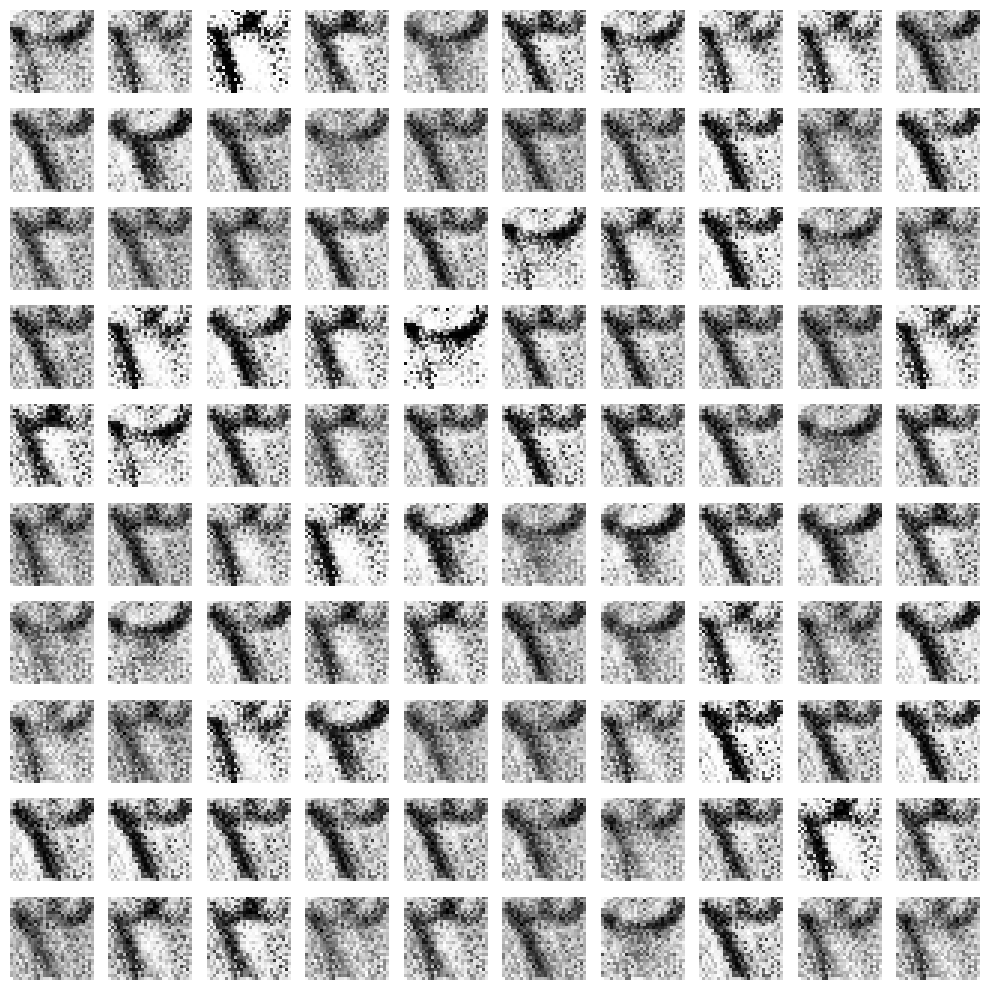

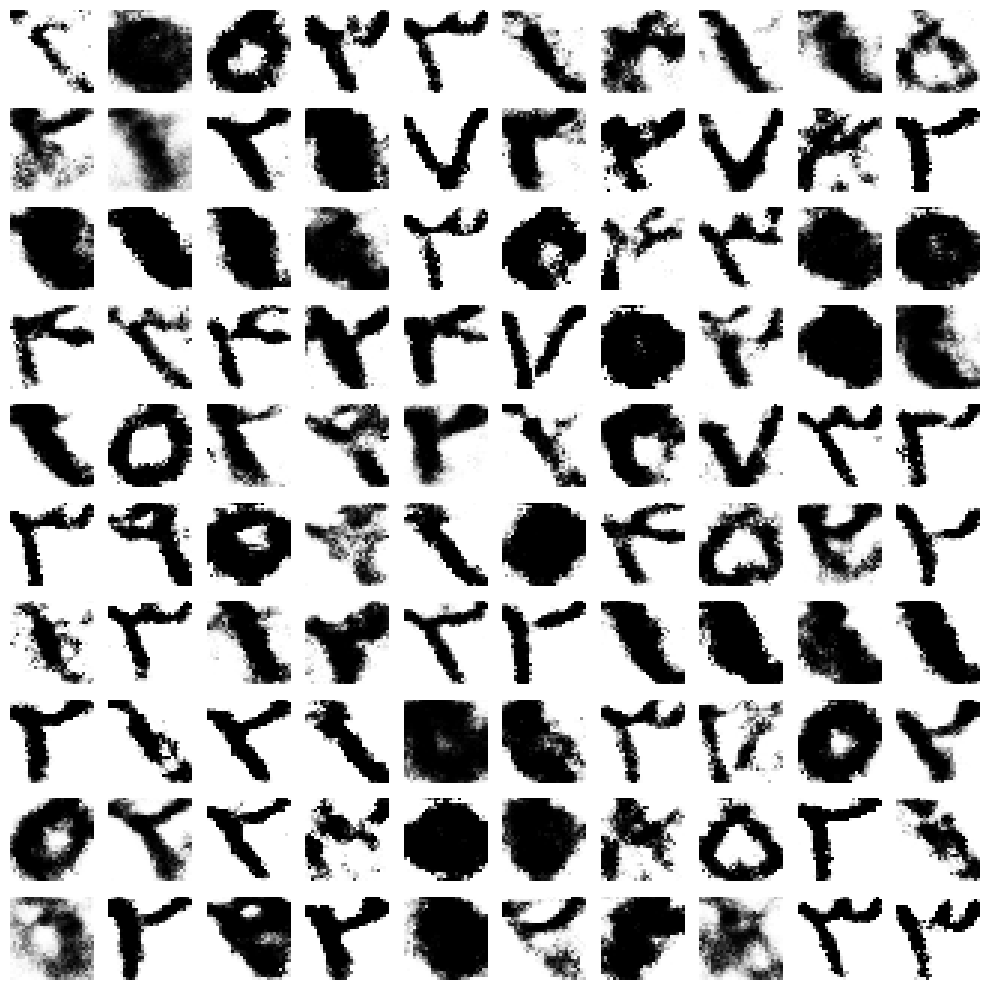

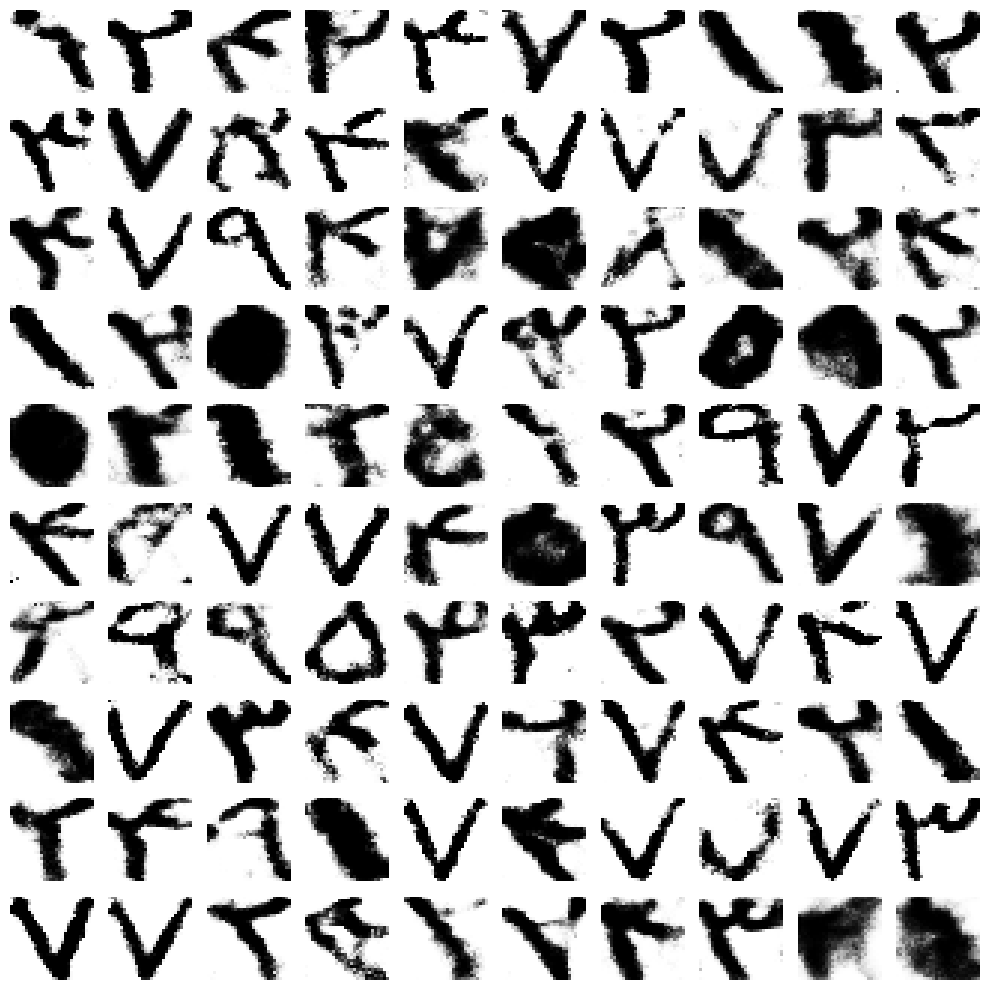

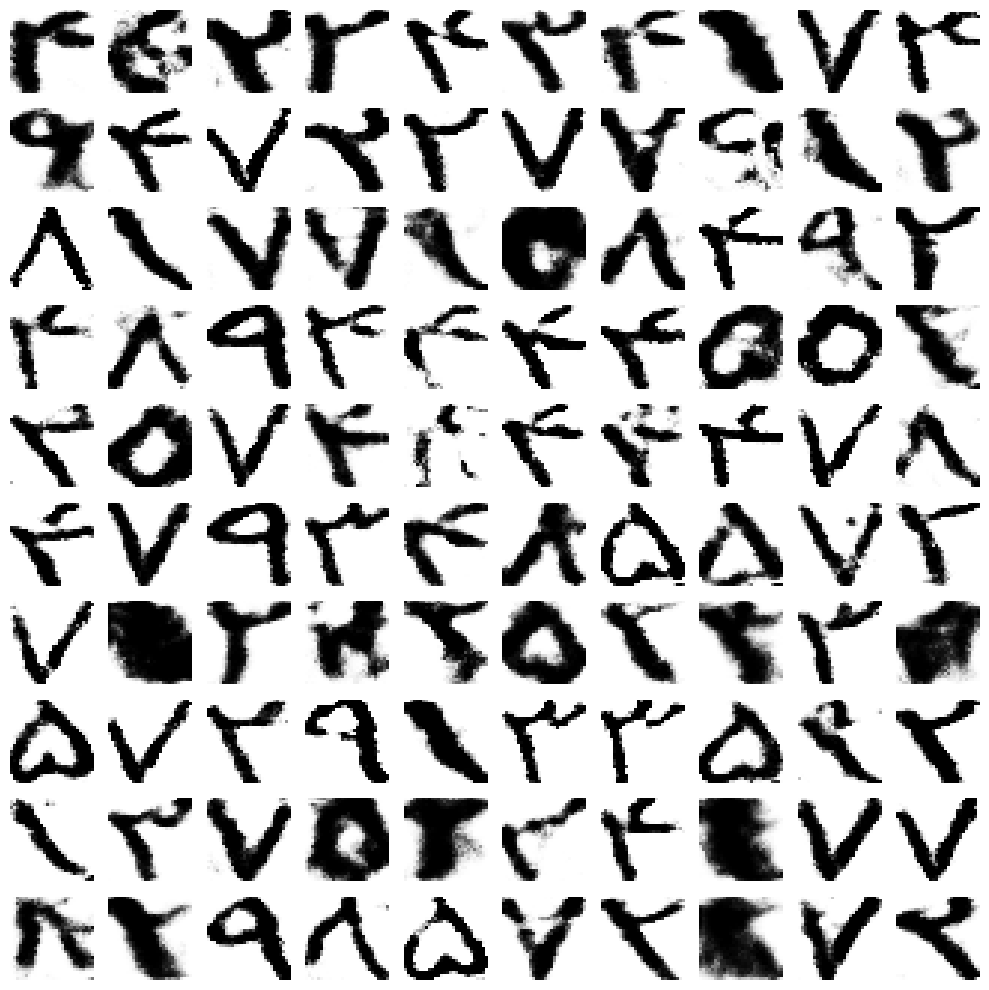

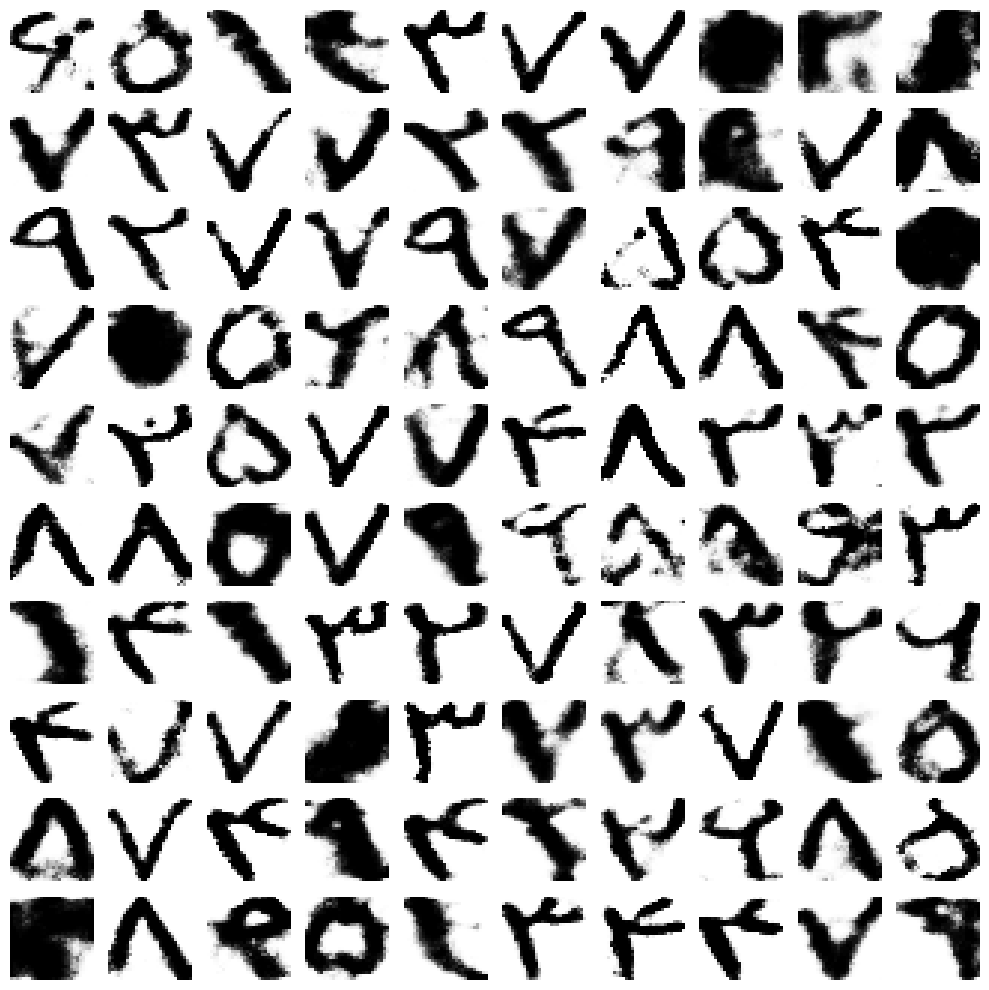

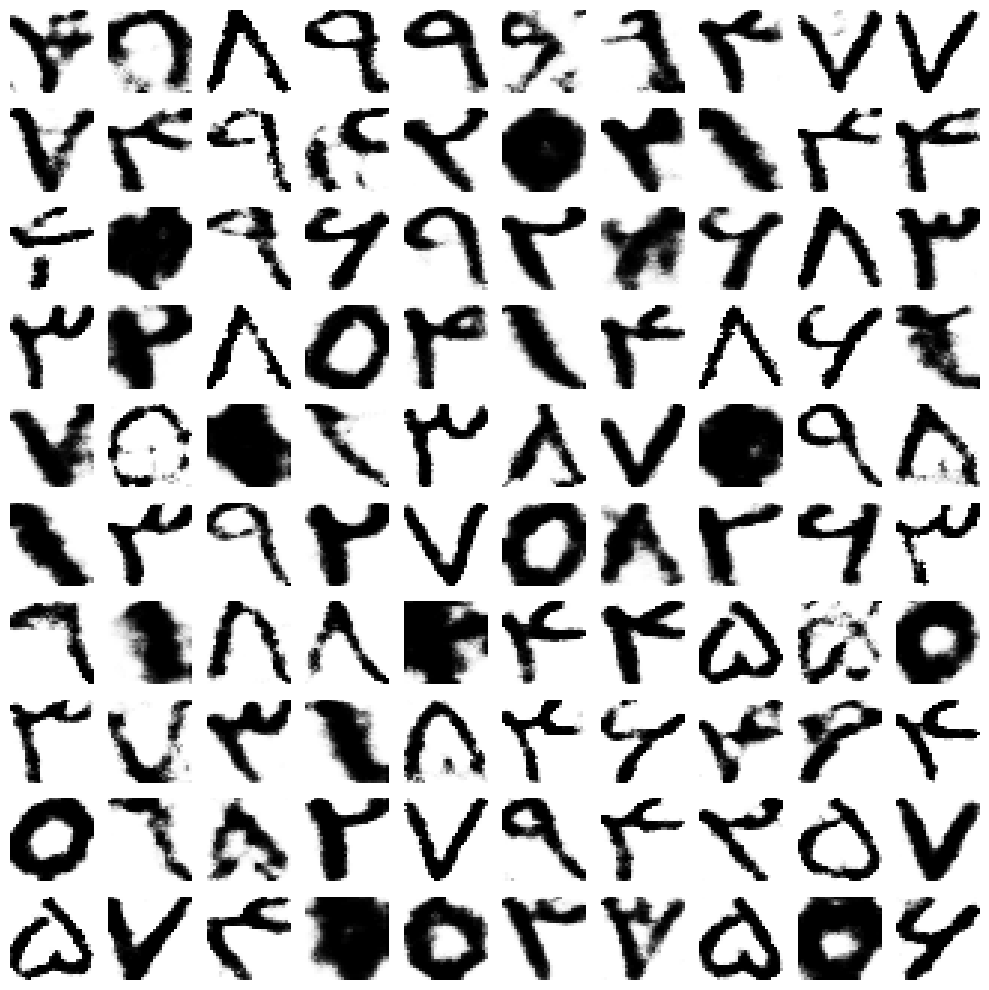

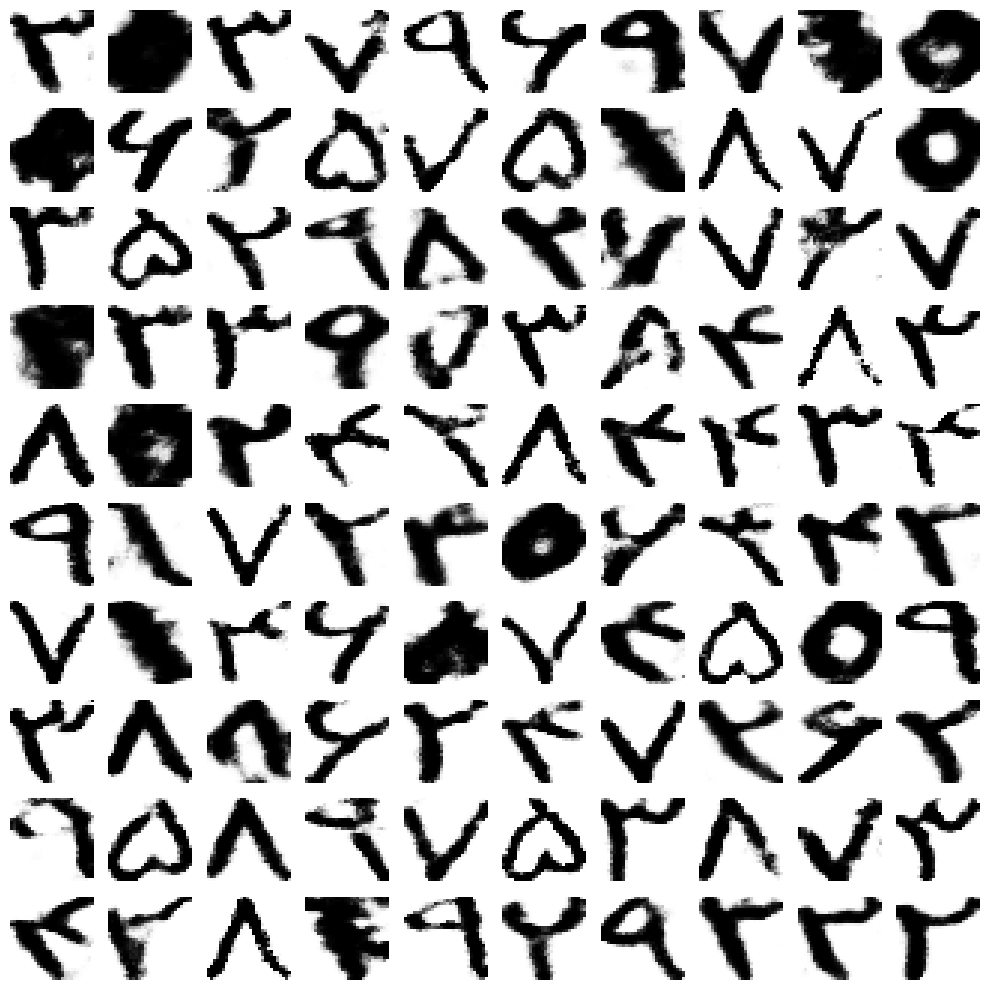

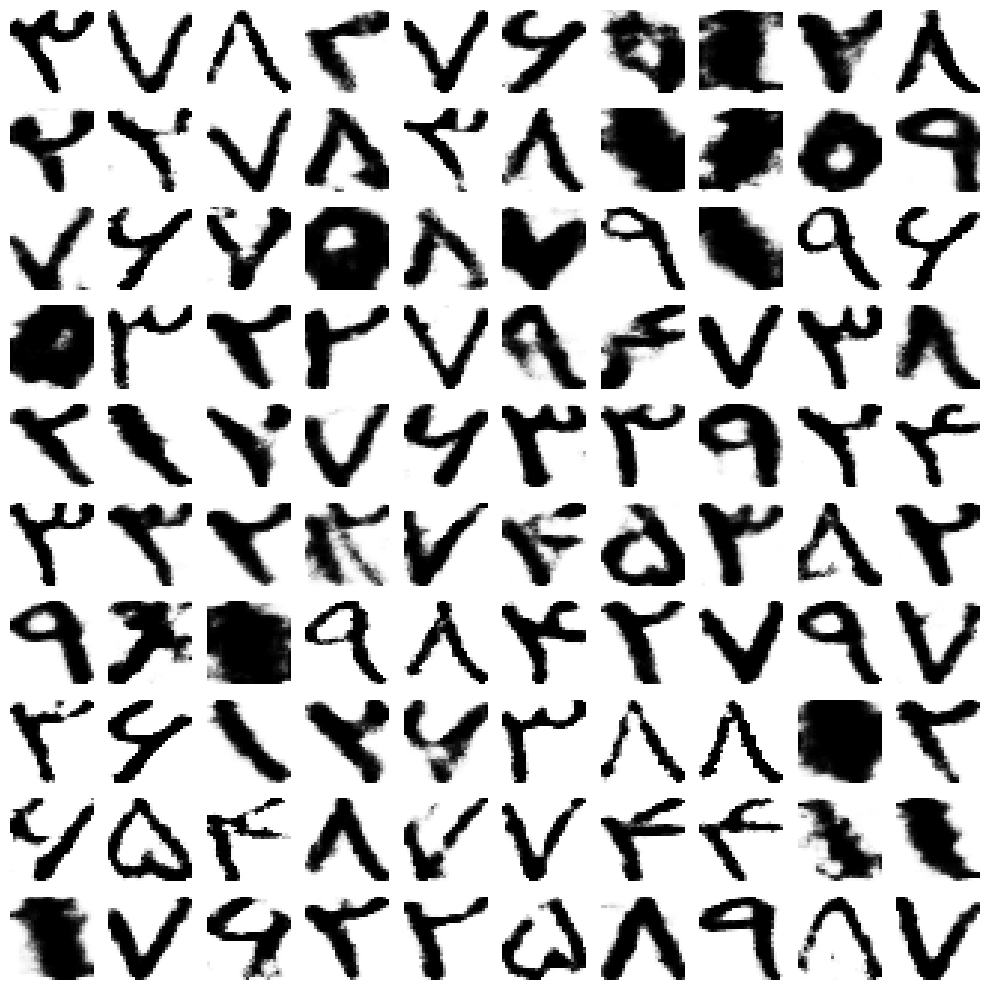

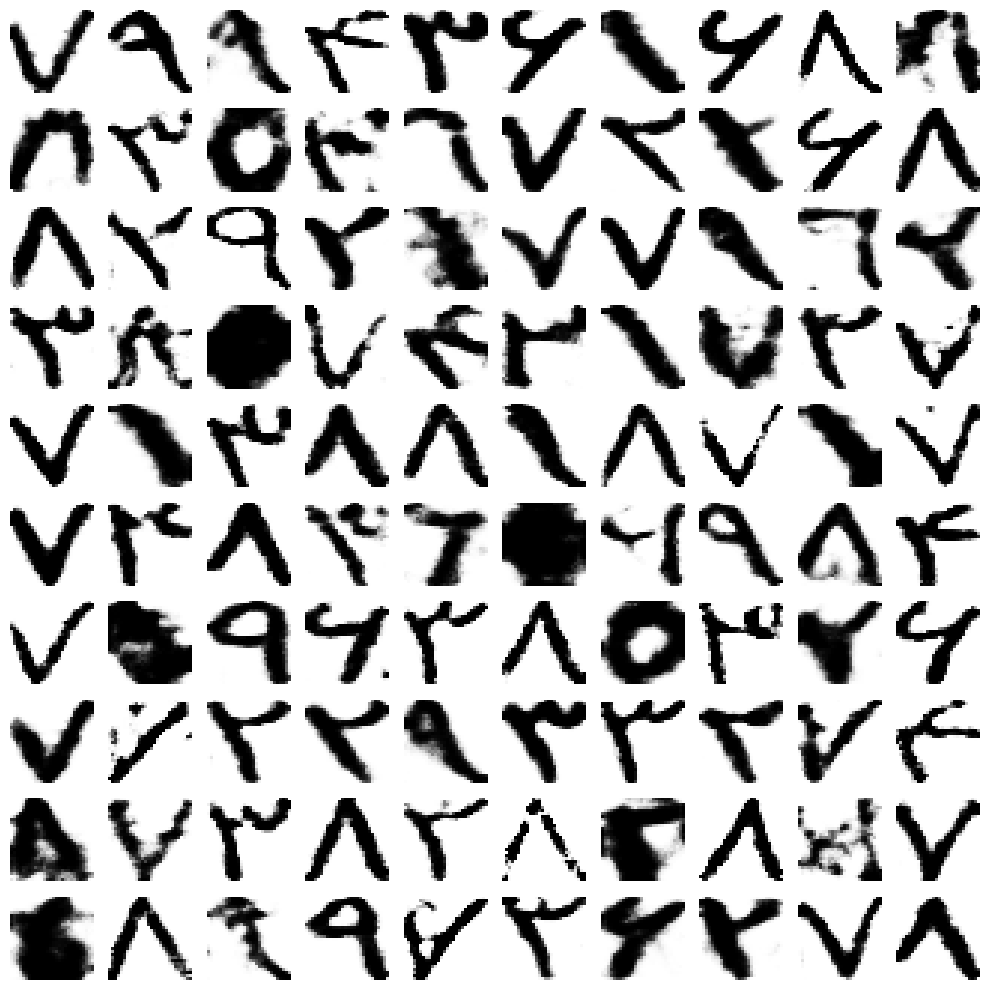

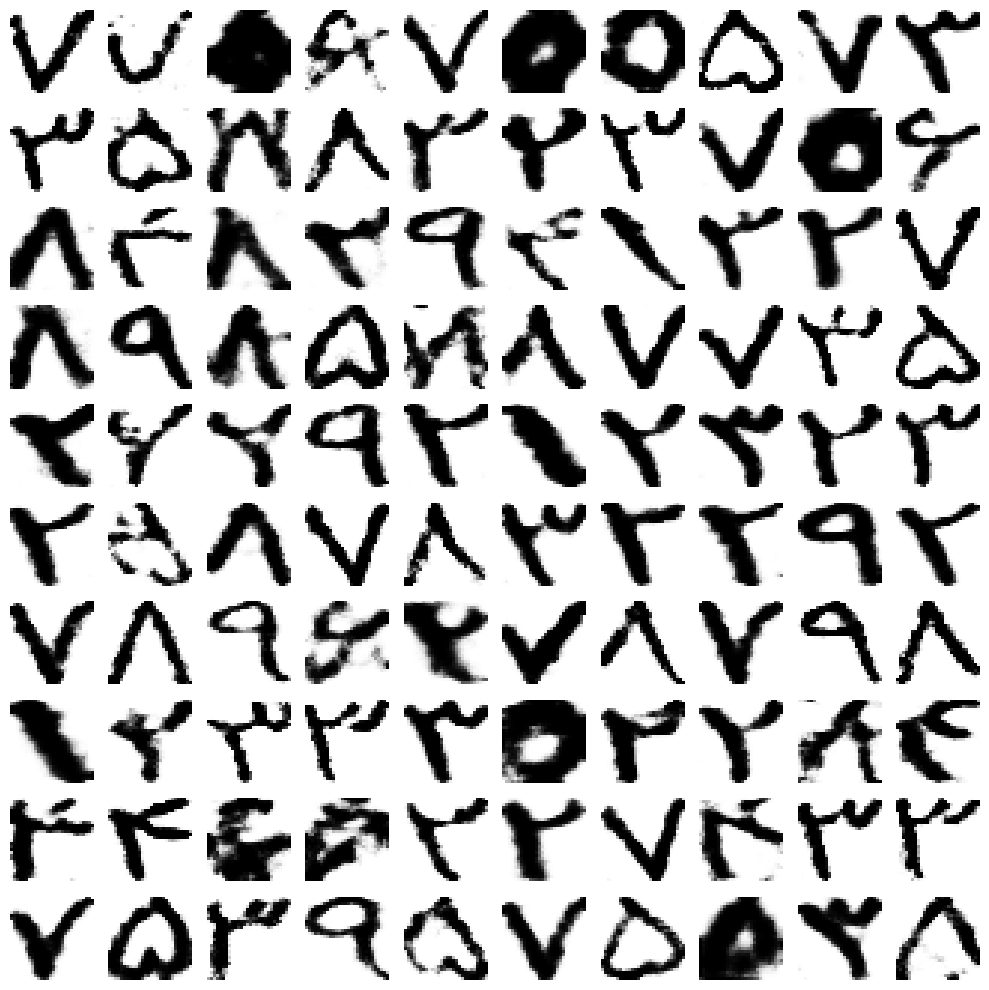

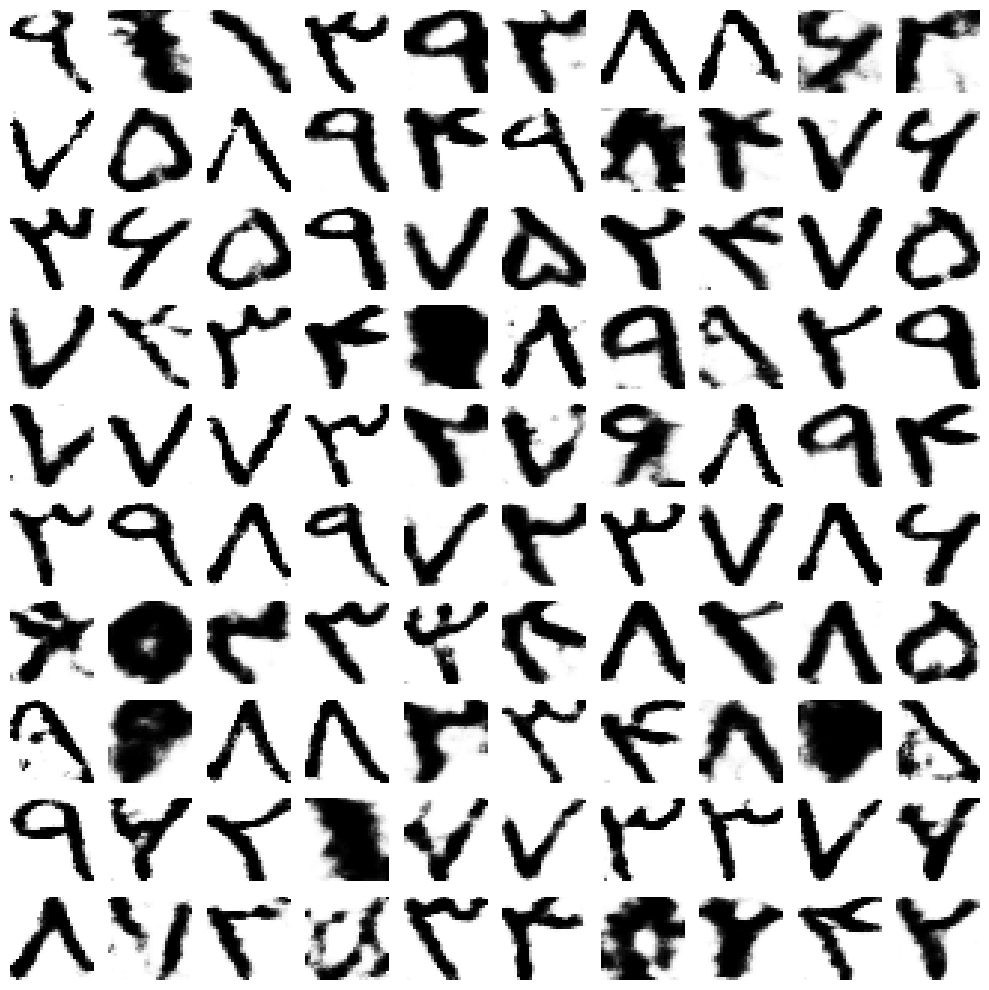

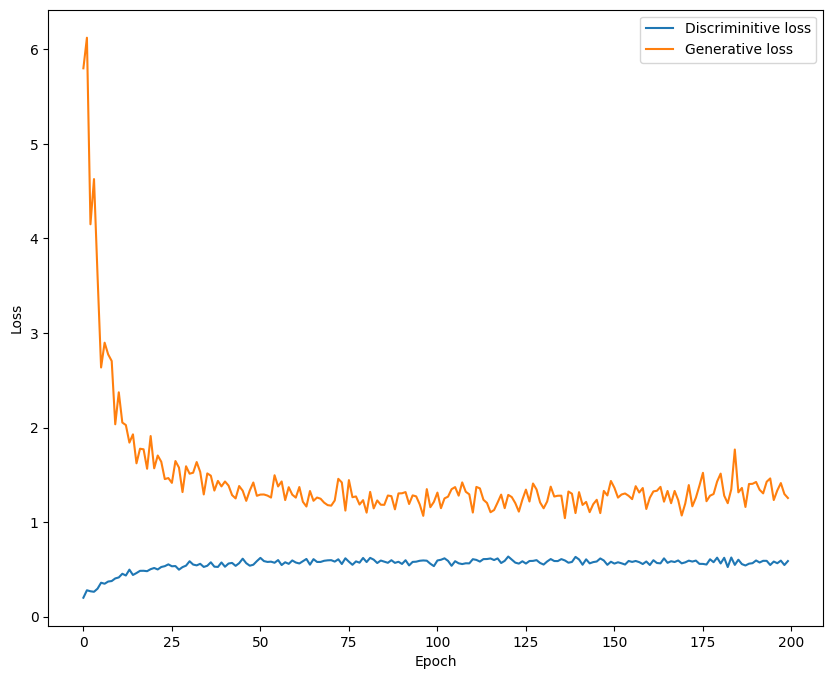

In [11]:
epochs=200
batchSize=128

batchCount = X_train.shape[0] // batchSize
print ('Epochs:', epochs)
print ('Batch size:', batchSize)
print ('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(batchCount)):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

        # Generate fake MNIST images
        generatedImages = generator.predict(noise, verbose=0)
        # print np.shape(imageBatch), np.shape(generatedImages)
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)

    if e == 1 or e % 20 == 0:
        plotGeneratedImages(e)
        saveModels(e)

# Plot losses from every epoch
plotLoss(e)

### <div style="direction:rtl;text-align:right;font-family:Tahoma">منابع:
</div>

[https://www.datacamp.com/community/tutorials/generative-adversarial-networks](https://www.datacamp.com/community/tutorials/generative-adversarial-networks)

[https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py](https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py)

<div class="alert alert-block alert-info">
<div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"> دانشگاه تربیت دبیر شهید رجایی<br>مباحث ویژه 2 - یادگیری عمیق پیشرفته<br>علیرضا اخوان پور<br>97-98<br>
</div>
<a href="https://www.srttu.edu/">SRTTU.edu</a> - <a href="http://class.vision">Class.Vision</a> - <a href="http://AkhavanPour.ir">AkhavanPour.ir</a>
</div>